# Tutorial: Initial Contact Detection

**Author:** Masoud Abedinifar

**Last update:** Thu 12 Dec 2024

## Learning objectives
By the end of this tutorial, you will be able to: 

- You can load data from a recording that belongs to one of the available datasets,
- Apply the Paraschiv-Ionescu initial contact detection algorithm to accelerometer data.  
- Extarct  the results of initial contact detection.
- Extract final contacts withing each gait seuqence.
- Extract different gait parameters including spatial, temporal, spatio-temporal and temporophasic parameters.

# Paraschiv Initial Contact Detection

This example can be referenced by citing the package.

The example illustrates how the Paraschiv initial contact detection algorithm is used to detect initial contacts using body acceleration recorded with a triaxial accelerometer worn or fixed on the lower back. The initial contact detection algorithm is implemented in the main module [`kielmat.modules.icd._paraschiv`](https://github.com/neurogeriatricskiel/KielMAT/tree/main/kielmat/modules/icd/_paraschiv.py). This algorithm is based on the research of Paraschiv-Ionescu et al [`1`-`2`].

The algorithm takes accelerometer data as input, specifically the vertical acceleration component, and processes each specified gait sequence independently. The algorithm requires the start and duration of each gait sequence, in the format provided by the Paraschiv-Ionescu gait sequence detection algorithm ([`kielmat.modules.gsd._paraschiv`](https://github.com/neurogeriatricskiel/KielMAT/tree/main/kielmat/modules/gsd/_paraschiv.py)). The sampling frequency of the accelerometer data is also required as another input. Detected gait sequence information is provided as a DataFrame, which consists of the onset and duration of the gait sequences. For each gait sequence, the algorithm applies the Signal Decomposition algorithm for initial contacts. The algorithm handles multiple gait sequences and ensures uniform output by padding the initial contacts lists with NaN values to match the length of the sequence with the maximum number of initial contacts detected among all sequences. Finally, initial contacts information is provided as a DataFrame with columns `onset`, `event_type`, `tracking_systems`, and `tracked_points`.

Additionally, final contacts (FC) are identified. Using both initial and final contact information, the spatial, temporophasic, temporal, and spatio-temporal parameters related to gait are calculated.

#### References
[`1`] Paraschiv-Ionescu et al. (2019). Locomotion and cadence detection using a single trunk-fixed accelerometer: validity for children with cerebral palsy in daily life-like conditions. Journal of NeuroEngineering and Rehabilitation, 16(1), 24. https://doi.org/10.1186/s12984-019-0494-z

[`2`] Paraschiv-Ionescu et al. (2020). Real-world speed estimation using a single trunk IMU: methodological challenges for impaired gait patterns. Annual International Conference of the IEEE Engineering in Medicine and Biology Society. IEEE Engineering in Medicine and Biology Society. https://doi.org/10.1109/EMBC44109.2020.9176281

## Import Libraries
The necessary libraries such as numpy, matplotlib.pyplot, dataset (keepcontrol), Paraschiv-Ionescu gait sequence detection, and Paraschiv-Ionescu initial contact detection algorithms are imported from their corresponding modules. Make sure that you have all the required libraries and modules installed before running this code. You also may need to install the `kielmat` library and its dependencies if you haven't already.

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
from kielmat.datasets import keepcontrol
from kielmat.modules.gsd import ParaschivIonescuGaitSequenceDetection
from kielmat.modules.icd import ParaschivIonescuInitialContactDetection
from kielmat.config import cfg_colors

## Data Preparation

To implement the Paraschiv-Ionescu initial contact algorithm, we load example data from a KeepControl, which is publicly available on [OpenNeuro](https://openneuro.org/datasets/ds005258). 

The participant was walking at a slow speed for a distance of 15m.

In [46]:
# Dataset path
dataset_path = Path(os.getcwd()) / "_keepcontrol"

# Fetch the dataset
keepcontrol.fetch_dataset(dataset_path)

In [47]:
# In this example, we use "imu" as tracking_system and "pelvis" as tracked points.
tracking_sys = "imu"
tracked_points = {tracking_sys: ["pelvis"]}

# The 'keepcontrol.load_recording' function is used to load the data from the specified file_path
recording = keepcontrol.load_recording(
    dataset_path=dataset_path,
    id="pp002",
    task="walkSlow",
    tracking_systems=[tracking_sys], 
    tracked_points=tracked_points
)

# Load lower back acceleration data
acceleration_data = recording.data[tracking_sys][
    ["pelvis_ACCEL_x", "pelvis_ACCEL_y", "pelvis_ACCEL_z"]
]

# Get the corresponding sampling frequency directly from the recording
sampling_frequency = recording.channels[tracking_sys][
    recording.channels[tracking_sys]["name"] == "pelvis_ACCEL_x"
]["sampling_frequency"].values[0]

#### Data Units and Conversion to SI Units

All input data provided to the modules in this toolbox should adhere to SI units to maintain consistency and accuracy across analyses. This ensures compatibility with the underlying algorithms, which are designed to work with standard metric measurements.

If any data is provided in non-SI units (e.g., acceleration in g instead of m/s²), it is needed that the data to be converted into the appropriate SI units before using it as input to the toolbox. Failure to convert non-SI units may lead to incorrect results or misinterpretation of the output.

For instance:

- **Acceleration:** Convert from g to m/s².

In [48]:
# Get the corresponding unit of the acceleration data
accel_unit = recording.channels[tracking_sys][
    recording.channels[tracking_sys]["name"].str.contains("ACCEL", case=False)
]["units"].iloc[0]

# Check unit of acceleration data
if accel_unit in ["m/s^2"]:
    pass  # No conversion needed
elif accel_unit in ["g", "G"]:
    # Convert acceleration data from "g" to "m/s^2"
    acceleration_data *= 9.81
    # Update unit of acceleration
    accel_unit = ["m/s^2"]

## Visualisation of the Data
The raw acceleration data including components of x, y and z axis is represented.

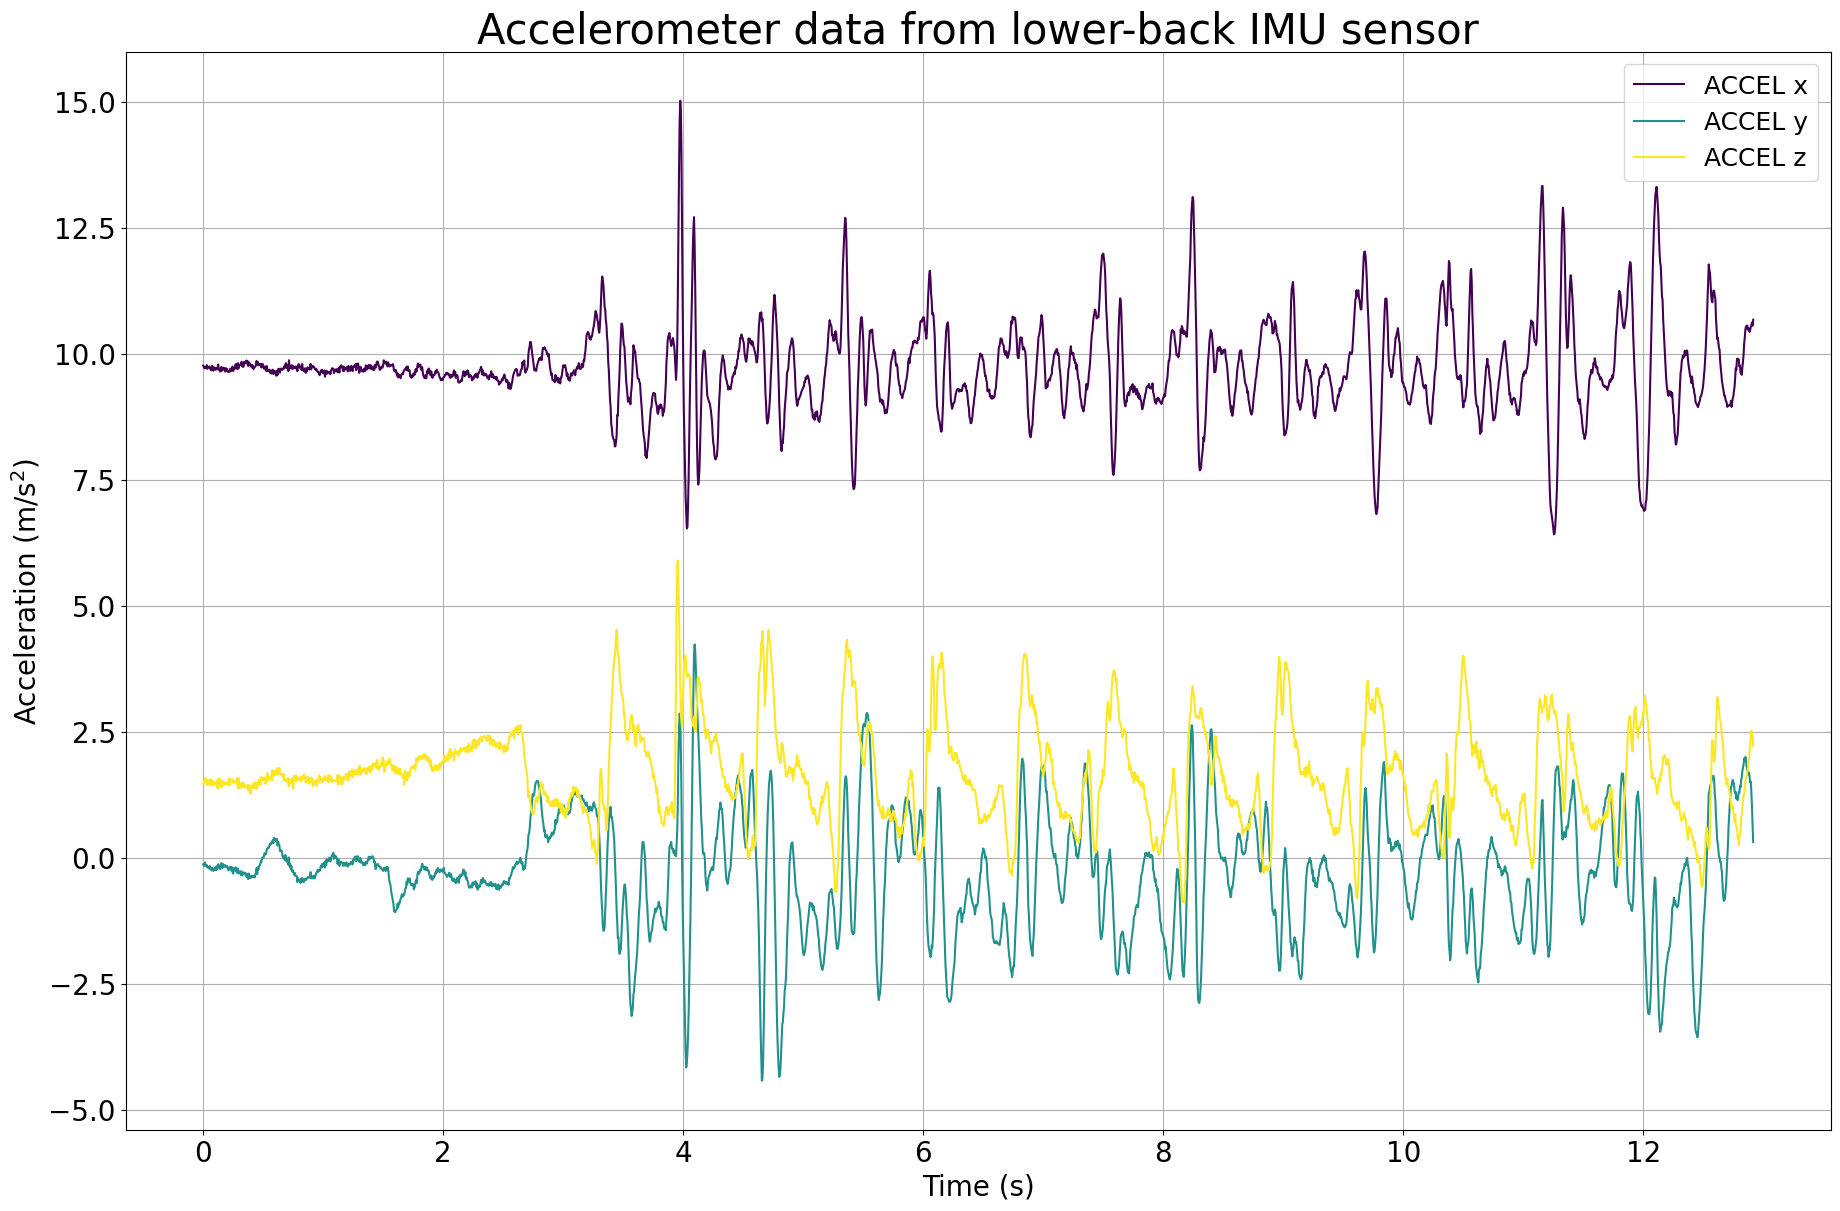

In [49]:
# Calculate the time values
time = np.arange(len(acceleration_data)) / (sampling_frequency)

# Create a figure with a specified size
plt.figure(figsize=(22, 14))

# Get colors for raw
colors = cfg_colors["raw"]

# A loop is used to plot data for each accelerometer axis
for i in range(3):
    plt.plot(
        time,
        acceleration_data.iloc[:,i],
        color=colors[i],
        label=f"ACCEL {'xyz'[i]}",
    )

# Add labels and legends
plt.xlabel("Time (s)", fontsize=20)
plt.ylabel("Acceleration (m/s$^{2}$)", fontsize=20)
plt.legend(fontsize=18)

# Add a title with a specified font size
plt.title(
    "Accelerometer data from lower-back IMU sensor",
    fontsize=30,
)

# Customize tick font sizes
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Display a grid for reference
plt.grid(visible=None, which="both", axis="both")

# Show the plot
plt.show()

## Applying Paraschiv-Ionescu Initial Contact Detection Algorithm
Now, we are running Paraschiv-Ionescu initial contact detection algorithm from icd module [`KielMAT.kielmat.modules.icd._paraschiv.ParaschivIonescuInitialContactDetection`](https://github.com/neurogeriatricskiel/KielMAT/tree/main/kielmat/modules/icd/_paraschiv.py) to detect initial contacts throughout the detected gait sequences. For this purpose, we have to first apply Paraschiv-Ionescu gait sequences detection algorithm to identify gait sequences using acceleration data. The gait sequences are detected by Paraschiv gait sequence detection ([`KielMAT.kielmat.modules.gsd._paraschiv.ParaschivIonescuGaitSequenceDetection`](https://github.com/neurogeriatricskiel/KielMAT/tree/main/kielmat/modules/gsd/_paraschiv.py)).

Then, in order to apply Paraschiv-Ionescu initial contact detection algorithm, an instance of the ParaschivIonescuInitialContactDetection class is created using the constructor, `ParaschivIonescuInitialContactDetection()`. The `icd` variable holds the instance, allowing us to access its methods. The inputs of Paraschiv-Ionescu initial contact detection algorithm are as follows:

- **Input Data:** `accel_data` consist of accelerometer data (N, 3) for the x, y, and z axes in pandas Dataframe format. The data should be in SI unit as m/s².
- **Gait Sequences:** `gait_sequences`, consist of gait sequences detected by Paraschiv gait sequence detection ([`KielMAT.kielmat.modules.gsd._paraschiv.ParaschivIonescuGaitSequenceDetection`](https://github.com/neurogeriatricskiel/KielMAT/tree/main/kielmat/modules/gsd/_paraschiv.py)).
- **Sampling Frequency:** `sampling_freq_Hz` is the sampling frequency of the data, defined in Hz.
- **Name of vertical accleration:** `v_acc_col_name` is the column name that corresponds to the vertical acceleration.



In [50]:
# Create an instance of the ParaschivIonescuGaitSequenceDetection class
gsd = ParaschivIonescuGaitSequenceDetection()

# Call the gait sequence detection using gsd.detect to detect gait sequences
gsd = gsd.detect(
    accel_data=acceleration_data, sampling_freq_Hz=200, plot_results=False
)

# Gait sequences are stored in gait_sequences_ attribute of gsd
gait_sequences = gsd.gait_sequences_

# Now, use Paraschiv-Ionescu initial contact detection algortihm to find initial contacts within detected gait sequences.
icd = ParaschivIonescuInitialContactDetection()

# Call the initial contact detection using icd.detect
icd = icd.detect(
    accel_data=acceleration_data,
    gait_sequences=gait_sequences,
    sampling_freq_Hz=200,
    v_acc_col_name="pelvis_ACCEL_x"
)

# Print initial contacts information
print(f"Initial contacts: {icd.initial_contacts_}")

1 gait sequence(s) detected.
Detected Initial Contacts (IC): [3.85, 4.45, 5.2, 5.875, 6.6, 7.35, 8.05, 8.8, 9.5, 10.25, 11.0, 11.725, 12.525]
Detected Final Contacts (FC): [3.5, 4.175, 4.825, 5.55, 6.225, 6.975, 7.7, 8.425, 9.15, 9.825, 10.625, 11.375, 12.275]
Initial contacts:      onset       event_type  duration tracking_systems
0    3.850  initial contact         0             None
1    4.450  initial contact         0             None
2    5.200  initial contact         0             None
3    5.875  initial contact         0             None
4    6.600  initial contact         0             None
5    7.350  initial contact         0             None
6    8.050  initial contact         0             None
7    8.800  initial contact         0             None
8    9.500  initial contact         0             None
9   10.250  initial contact         0             None
10  11.000  initial contact         0             None
11  11.725  initial contact         0             None
12  12

### Final Contact Detection

In addition to initial contacts, the final contacts could be extracted using the `final_contacts_` method. The Final contact inofrmation are provided as a DataFrame with columns `onset`, `event_type`, and `tracking_systems`. 

In [51]:
# Print final contact information
print(f"Final contacts: {icd.final_contacts_}")

Final contacts:      onset     event_type  duration tracking_systems
0    3.500  final contact         0             None
1    4.175  final contact         0             None
2    4.825  final contact         0             None
3    5.550  final contact         0             None
4    6.225  final contact         0             None
5    6.975  final contact         0             None
6    7.700  final contact         0             None
7    8.425  final contact         0             None
8    9.150  final contact         0             None
9    9.825  final contact         0             None
10  10.625  final contact         0             None
11  11.375  final contact         0             None
12  12.275  final contact         0             None


### Extraction of Temporal Parameters

Next, the temporal gait parameters could be extracted using the `temporal_parameters`. The outputs are stored in the `temporal_parameters_`.

In [52]:
# Call the temporal_parameters object for extracting the temporal gait parameters
icd.temporal_parameters()

# Print temporal parameters for each gait
print(icd.temporal_parameters_)

   gait_sequence_id                            step_time_l  \
0                 0  [0.6, 0.675, 0.75, 0.75, 0.75, 0.725]   

                     step_time_r                 stride_time_l  \
0  [0.75, 0.725, 0.7, 0.7, 0.75]  [1.35, 1.4, 1.45, 1.45, 1.5]   

                       stride_time_r                       stance_time_l  \
0  [1.425, 1.475, 1.45, 1.45, 1.475]  [1.025, 1.05, 1.075, 1.075, 1.175]   

                  stance_time_r                        swing_time_l  \
0  [1.05, 1.125, 1.1, 1.1, 1.1]  [0.325, 0.35, 0.375, 0.375, 0.325]   

                       swing_time_r              single_support_time_l  \
0  [0.375, 0.35, 0.35, 0.35, 0.375]  [0.375, 0.375, 0.35, 0.35, 0.375]   

                 single_support_time_r             double_support_time_l  \
0  [0.275, 0.325, 0.375, 0.375, 0.425]  [0.65, 0.675, 0.725, 0.725, 0.8]   

               double_support_time_r  cadence  
0  [0.775, 0.8, 0.725, 0.725, 0.675]    89.91  


### Extraction of Temporophasic Parameters

Next, the temporophasic gait parameters could be extracted using the `temporophasic_parameters`. The outputs are stored in the `temporophasic_parameters_`.

In [53]:
# Call the temporophasic_parameters_ object for extracting the temporophasic parameters
icd.temporophasic_parameters()

# Print temporophasic parameters for each gait
print(icd.temporophasic_parameters_)

   gait_sequence_id                stance_time_pct_gc_l  \
0                 0  [75.93, 75.0, 74.14, 74.14, 78.33]   

                  stance_time_pct_gc_r                 swing_time_pct_gc_l  \
0  [73.68, 76.27, 75.86, 75.86, 74.58]  [24.07, 25.0, 25.86, 25.86, 21.67]   

                   swing_time_pct_gc_r        single_support_time_pct_gc_l  \
0  [26.32, 23.73, 24.14, 24.14, 25.42]  [27.78, 26.79, 24.14, 24.14, 25.0]   

         single_support_time_pct_gc_r       double_support_time_pct_gc_l  \
0  [19.3, 22.03, 25.86, 25.86, 28.81]  [48.15, 48.21, 50.0, 50.0, 53.33]   

        double_support_time_pct_gc_r  
0  [54.39, 54.24, 50.0, 50.0, 45.76]  


### Extraction of Spatial Parameters

Next, the temporophasic gait parameters can be extracted using the `spatial_parameters` method. The outputs are stored in `spatial_parameters_`. The method requires the total walking distance to be provided.

In [54]:
# # Call the spatial_parameters object for extracting the spatial parameters
icd.spatial_parameters(total_distance_m=15)

# # Print spatial parameters for each gait
print(icd.spatial_parameters_)

   gait_sequence_id                           step_lengths_l  \
0                 0  [0.624, 0.702, 0.78, 0.78, 0.78, 0.754]   

                      step_lengths_r                    stride_lengths_l  \
0  [0.78, 0.754, 0.728, 0.728, 0.78]  [1.404, 1.456, 1.508, 1.508, 1.56]   

                      stride_lengths_r  
0  [1.482, 1.534, 1.508, 1.508, 1.534]  


### Extraction of Spatio-temporal Parameters

Next, the spatio-temporal gait parameters can be extracted using the `spatio_temporal_parameters` method. The outputs are stored in `spatial_parameters_`. The method requires the total walking distance to be provided.

In [55]:
# Call the spatio_temporal_parameters object for extracting the spatio-temporal gait parameters
icd.spatio_temporal_parameters(total_distance_m=15)

# Print spatio-temporal parameters for each gait
print(icd.spatio_temporal_parameters_)

   gait_sequence_id  gait_speed                  stride_speed_l  \
0                 0        1.04  [1.04, 1.04, 1.04, 1.04, 1.04]   

                   stride_speed_r  
0  [1.04, 1.04, 1.04, 1.04, 1.04]  
